Импорт основных библиотек.
В качестве библиотеки ML выбрана TensorFlow

In [4]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Concatenate, Activation, UpSampling2D, Conv2D, MaxPooling2D
# Все служебные функции перенесены в файл utils.py
from utils import *

Проведем предварительный аналз ДатаСета, 

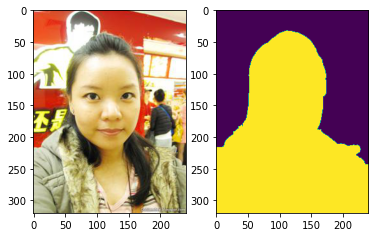

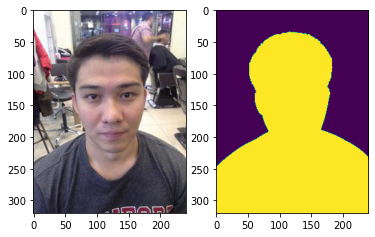

In [47]:
for i in range(2):
    fig, ax = plt.subplots(1,2)
    img = PIL.Image.open(f'./data/train/{i}.jpg')
    mask = PIL.Image.open(f'./data/train_mask/{i}.png')
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()

In [48]:
# Определим размеры изображений
img = PIL.Image.open('./data/train/0.jpg')
mask = PIL.Image.open('./data/train_mask/0.png')
print(f'Размер основного изображения - {img.size}')
print(f'Размер маски - {mask.size}')

Размер основного изображения - (240, 320)
Размер маски - (240, 320)


Директории расположеия изображений

In [5]:
TRAIN_PATH = "./data/train/train/"
VALID_PATH = "./data/valid/valid/"

Для создания пайплайна по предварительной обработке воспользуюсь средсвами библиотки TensorFlow. Загрузим список всх изображений (исходных и масок)

In [7]:
# Тренировочный датасет
train_img_ds = tf.data.Dataset.list_files(VALID_PATH + '*.jpg', shuffle=False)
# Валидационный датасет
valid_img_ds = tf.data.Dataset.list_files(VALID_PATH + '*.jpg', shuffle=False)

Применение функций для предобработки изображений

In [9]:
train_ds = train_img_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = valid_img_ds.map(preprocess_valid, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(10).prefetch(1)
validation_ds = validation_ds.batch(10).prefetch(1)

Ниже реализована модель нейроннной сети типа UNET. Данная архитектура прозводит кодирование/декодирование изображения.

In [11]:
input_layer = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(input_layer)
conv_1_1 = Activation('relu')(conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)
conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)
pool_5 = MaxPooling2D(2)(conv_5_2)

conv_6_1 = Conv2D(1024, (3, 3), padding='same')(pool_5)
conv_6_1 = Activation('relu')(conv_6_1)
conv_6_2 = Conv2D(1024, (3, 3), padding='same')(conv_6_1)
conv_6_2 = Activation('relu')(conv_6_2)
pool_6 = MaxPooling2D(2)(conv_6_2)

conv_7_1 = Conv2D(2048, (3, 3), padding='same')(pool_6)
conv_7_1 = Activation('relu')(conv_7_1)
conv_7_2 = Conv2D(2048, (3, 3), padding='same')(conv_7_1)
conv_7_2 = Activation('relu')(conv_7_2)
pool_7 = MaxPooling2D(2)(conv_7_2)

####
####

up_7 = UpSampling2D(2, interpolation='bilinear')(pool_7)
conc_7 = Concatenate()([conv_7_2, up_7])
conv_up_7_1 = Conv2D(2048, (3, 3), padding='same')(conc_7)
conv_up_7_1 = Activation('relu')(conv_up_7_1)
conv_up_7_2 = Conv2D(2048, (3, 3), padding='same')(conv_up_7_1)

up_6 = UpSampling2D(2, interpolation='bilinear')(pool_6)
conc_6 = Concatenate()([conv_6_2, up_6])
conv_up_6_1 = Conv2D(1024, (3, 3), padding='same')(conc_6)
conv_up_6_1 = Activation('relu')(conv_up_6_1)
conv_up_6_2 = Conv2D(1024, (3, 3), padding='same')(conv_up_6_1)

up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_6_2)
conc_5 = Concatenate()([conv_5_2, up_5])
conv_up_5_1 = Conv2D(256, (3, 3), padding='same')(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)
conv_up_5_2 = Conv2D(256, (3, 3), padding='same')(conv_up_5_1)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_5_2)
conc_4 = Concatenate()([conv_4_2, up_4])
conv_up_4_1 = Conv2D(256, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)
conv_up_4_2 = Conv2D(256, (3, 3), padding='same')(conv_up_4_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_3 = Concatenate()([conv_3_2, up_3])
conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)
conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_2 = Concatenate()([conv_2_2, up_2])
conv_up_2_1 = Conv2D(64, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)
conv_up_2_2 = Conv2D(64, (3, 3), padding='same')(conv_up_2_1)

up_1 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_1 = Concatenate()([conv_1_2, up_1])
conv_up_1_1 = Conv2D(32, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)
conv_up_1_2 = Conv2D(3, (3, 3), padding='same')(conv_up_1_1)

output_layer = Activation('sigmoid')(conv_up_1_2)
model = Model(inputs=input_layer, outputs=output_layer)

Производится компиляция модели.

In [43]:
model.compile(
    keras.optimizers.Adam(learning_rate=0.001), 
    'binary_crossentropy', 
)

 Добавлены колбэки 

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint('unet_best.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto'), 
    keras.callbacks.ModelCheckpoint('unet_last.h5', monitor='loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto')
]

In [45]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=120,
  callbacks=callbacks
)

Epoch 1/120
2/2 [==============================] - 2s 637ms/step - loss: 119.3956
Epoch 2/120
2/2 [==============================] - 1s 640ms/step - loss: 0.6324
Epoch 3/120
2/2 [==============================] - 1s 639ms/step - loss: 0.4343
Epoch 4/120
2/2 [==============================] - 1s 612ms/step - loss: 0.4653
Epoch 5/120
2/2 [==============================] - 1s 614ms/step - loss: 0.4628
Epoch 6/120
2/2 [==============================] - 1s 614ms/step - loss: 0.4847
Epoch 7/120
2/2 [==============================] - 1s 614ms/step - loss: 0.4512
Epoch 8/120
2/2 [==============================] - 1s 608ms/step - loss: 0.4500
Epoch 9/120
2/2 [==============================] - 1s 607ms/step - loss: 0.4361
Epoch 10/120
2/2 [==============================] - 1s 678ms/step - loss: 0.4001
Epoch 11/120
2/2 [==============================] - 1s 639ms/step - loss: 0.5907
Epoch 12/120
2/2 [==============================] - 1s 651ms/step - loss: 0.4652
Epoch 13/120
2/2 [=================

In [36]:
#model = tf.keras.models.load_model("unet_best.h5")

In [46]:
test_img = cv2.imread("./fish/train/00002.png")
test_img = cv2.resize(test_img, (240, 320), interpolation = cv2.INTER_AREA)
test_img_ex = np.expand_dims(test_img, axis=0)

In [47]:
res = model.predict(test_img_ex)

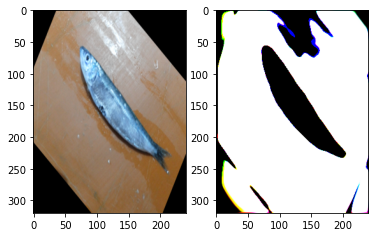

In [48]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_img)
ax[1].imshow(res[0])